In [49]:
import pandas as pd
import numpy as np
import re
from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM
from keras.layers import GlobalMaxPooling1D
from keras.models import Model
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.layers import Input
from keras.layers.merge import Concatenate



import matplotlib.pyplot as plt

In [52]:
train_data = pd.read_csv('/content/20191226-items.csv')
train_data.shape
train_data

,id,service_name,service_category
0,0,Dual-Band / Tri-Mode Sprint PCS Phone w/ Voice...,Motorola
1,1,Motorola I265 phone,Motorola
2,2,MOTOROLA C168i AT&T CINGULAR PREPAID GOPHONE C...,Motorola
3,3,Motorola i335 Cell Phone Boost Mobile,Motorola
4,4,Motorola V365 no contract cellular phone AT&T,Motorola
5,6,"Samsung Alias2 U750 Phone, Black (Verizon Wire...",Samsung
6,7,"Samsung Alias2 U750 Phone, Black (Verizon Wire...",Samsung
7,8,"Samsung Alias2 U750 Phone, Black (Verizon Wire...",Samsung
8,9,"Samsung Alias2 U750 Phone, Black (Verizon Wire...",Samsung


In [53]:
train_data.isnull().sum()

id                  0
service_name        0
service_category    0
dtype: int64

In [12]:
train_data.dropna()

,asin,service_name,service_category
0,B000SKTZ0S,MOTOROLA C168i AT&T CINGULAR PREPAID GOPHONE C...,Motorola
1,B001AO4OUC,Motorola i335 Cell Phone Boost Mobile,Motorola
2,B001DCJAJG,Motorola V365 no contract cellular phone AT&T,Motorola
3,B0029F2O3A,"Samsung Alias2 U750 Phone, Black (Verizon Wire...",Samsung
4,B002AS9WEA,Samsung a167 Prepaid GoPhone (AT&T),Samsung
5,B0033SFV5A,Verizon or PagePlus Samsung Smooth U350 Great ...,Samsung


In [13]:
train_data.isnull().sum()

asin                2
service_name        2
service_category    2
dtype: int64

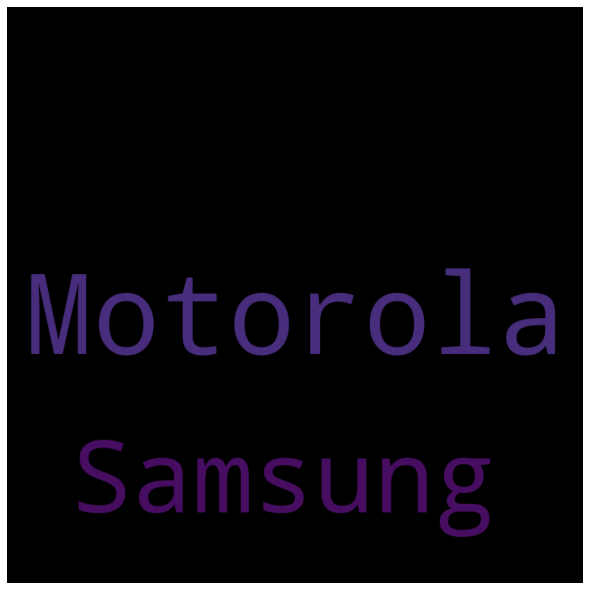

In [54]:
from wordcloud import WordCloud
def plot_word_cloud(text):
    wordcloud_instance = WordCloud(width = 800, height = 800, 
                background_color ='black', 
                stopwords=None,
                min_font_size = 10).generate(text) 
             
    plt.figure(figsize = (8, 8), facecolor = None) 
    plt.imshow(wordcloud_instance) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.show()
        
tags = ''
for index, row in train_data.iterrows():
    tags = tags + ',' + str(row['service_category'])
plot_word_cloud(tags)

In [55]:
from gensim import utils
def clean_text(s):
    s = s.lower()
    s = utils.to_unicode(s)
    for f in filters:
        s = f(s)
    return s

import gensim.parsing.preprocessing as gsp

filters = [
           gsp.strip_tags, 
           gsp.strip_punctuation,
           gsp.strip_multiple_whitespaces,
           gsp.strip_numeric,
           gsp.remove_stopwords, 
           gsp.strip_short, 
           gsp.stem_text
          ]

def plot_word_cloud_of_body_for_tag(tag_name):
    tag_specific_body = ''
    tag_specific_df = train_data[train_data['service_category'].str.contains(tag_name)]

    for index, row in tag_specific_df.iterrows():
        tag_specific_body = tag_specific_body + ' ' + clean_text(row['service_name'])
    
    plot_word_cloud(tag_specific_body)

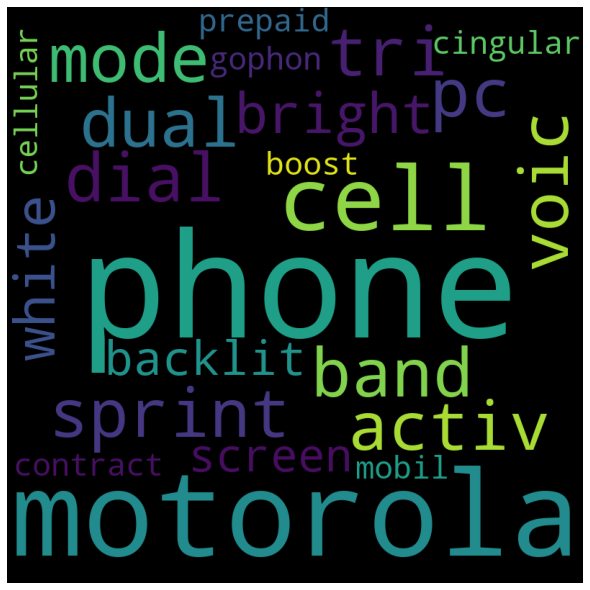

In [56]:
plot_word_cloud_of_body_for_tag('Motorola')

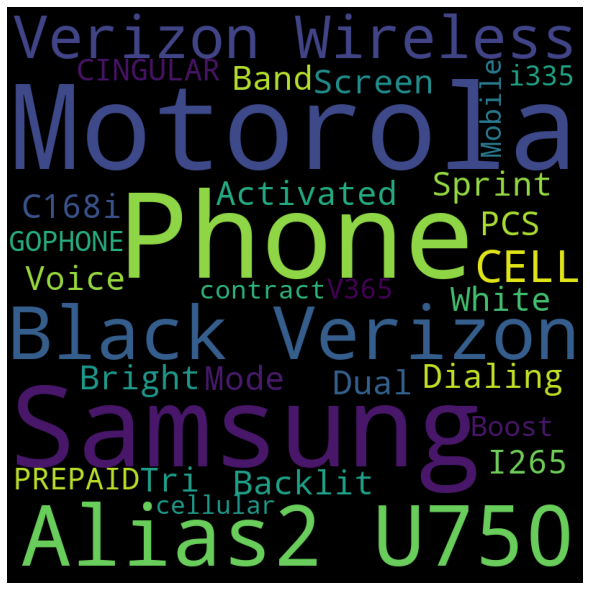

In [57]:
for index, row in train_data.iterrows():
    tags = tags + ',' + str(row['service_name'])
plot_word_cloud(tags)

In [58]:
def remove_spaces(x):
    x=x.split(",")
    nospace=[]
    for item in x:
        item=item.lstrip()
        nospace.append(item)
    return (",").join(nospace)
train_data['service_category']=train_data['service_category'].apply(remove_spaces)
train_data['service_category'] = train_data['service_category'].str.split(",", expand = False)
from sklearn.preprocessing import MultiLabelBinarizer

multilabel_binarizer = MultiLabelBinarizer()
multilabel_binarizer.fit(train_data['service_category'])

# transform target variable
y = multilabel_binarizer.transform(train_data['service_category'])


In [59]:
y

array([[1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1]])

In [60]:
labels = multilabel_binarizer.classes_
labels

array(['Motorola', 'Samsung'], dtype=object)

In [61]:
for idx, cat in enumerate(multilabel_binarizer.classes_):
    train_data[cat] = y[:,idx]
train_data.head(5)

,id,service_name,service_category,Motorola,Samsung
0,0,Dual-Band / Tri-Mode Sprint PCS Phone w/ Voice...,[Motorola],1,0
1,1,Motorola I265 phone,[Motorola],1,0
2,2,MOTOROLA C168i AT&T CINGULAR PREPAID GOPHONE C...,[Motorola],1,0
3,3,Motorola i335 Cell Phone Boost Mobile,[Motorola],1,0
4,4,Motorola V365 no contract cellular phone AT&T,[Motorola],1,0


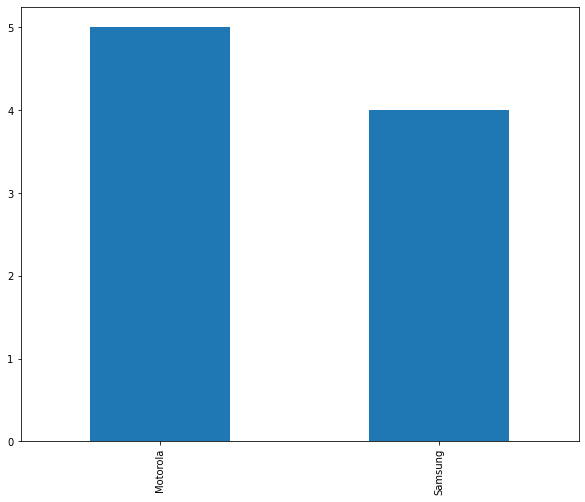

In [62]:
train_data_labels = train_data[['Motorola', 'Samsung']]
train_data_labels.head()
import matplotlib.pyplot as plt
%matplotlib inline
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 8
plt.rcParams["figure.figsize"] = fig_size

train_data_labels.sum(axis=0).plot.bar()

In [63]:
category = pd.DataFrame(train_data_labels.sum()).reset_index().rename(columns = {'index':'service_category',0:'count'})
category.head()

,service_category,count
0,Motorola,5
1,Samsung,4


In [64]:
category['class_weight'] = len(category) / category['count']
class_weight = {}
for index, label in enumerate(labels):
  class_weight[index] = category[category['service_category'] == label]['class_weight'].values[0]
    
category.head()

,service_category,count,class_weight
0,Motorola,5,0.4
1,Samsung,4,0.5


In [65]:
category.sort_values('count')

,service_category,count,class_weight
1,Samsung,4,0.5
0,Motorola,5,0.4


In [66]:
def get_features(text_series):
    """
    transforms text data to feature_vectors that can be used in the ml model.
    tokenizer must be available.
    """
    sequences = tokenizer.texts_to_sequences(text_series)
    return pad_sequences(sequences, maxlen=maxlen)

In [67]:
train_data.service_name.map(lambda x: len(x)).max()

94

In [69]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.text import Tokenizer
maxlen = 3
tokenizer = Tokenizer(num_words=10)
max_words = len(tokenizer.word_index) + 1
tokenizer = Tokenizer(num_words=max_words, lower=True)
tokenizer.fit_on_texts(train_data.service_name)

# x = get_features(train_data.service_name)
x = get_features(train_data.service_name)
print(x.shape)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)
print(x_test.shape,y_test.shape)


(9, 3)
(2, 3) (2, 2)


In [82]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Embedding, Flatten, GlobalMaxPool1D, Dropout, Conv1D
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from keras.losses import binary_crossentropy
from tensorflow.keras.optimizers import Adam

filter_length = 6
num_classes = 2
model = Sequential()
model.add(Embedding(max_words, 2, input_length=maxlen))
model.add(Dropout(0.1))
model.add(Conv1D(filter_length, 3, padding='valid', activation='relu', strides=1))
model.add(GlobalMaxPool1D())
model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

callbacks = [
  ReduceLROnPlateau(), 
  EarlyStopping(patience=4), 
  ModelCheckpoint(filepath='model-conv1d1.h5', save_best_only=True)
]

history = model.fit(x_train, y_train,
                  class_weight=class_weight,
                  epochs=3,
                  batch_size=2,
                  validation_split=0.1,
                  callbacks=callbacks
                  )

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 3, 2)              2         
                                                                 
 dropout_7 (Dropout)         (None, 3, 2)              0         
                                                                 
 conv1d_7 (Conv1D)           (None, 1, 6)              42        
                                                                 
 global_max_pooling1d_7 (Glo  (None, 6)                0         
 balMaxPooling1D)                                                
                                                                 
 dense_7 (Dense)             (None, 2)                 14        
                                                                 
 activation_7 (Activation)   (None, 2)                 0         
                                                      

In [83]:
from keras.models import load_model
cnn_model = load_model('model-conv1d1.h5')
metrics = cnn_model.evaluate(x_test, y_test)
print("{}: {}".format(cnn_model.metrics_names[0], metrics[0]))
print("{}: {}".format(cnn_model.metrics_names[1], metrics[1]))

1/1 [==============================] - 0s 116ms/step - loss: 0.6932 - accuracy: 0.5000
loss: 0.6931702494621277
accuracy: 0.5


In [84]:
from keras.models import load_model
model = load_model('/content/model-conv1d1.h5')
metrics = model.evaluate(x_test, y_test)

1/1 [==============================] - 0s 119ms/step - loss: 0.6932 - accuracy: 0.5000


In [85]:
import pickle
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [86]:
cnn_model = load_model('/content/model-conv1d1.h5')
tokenizer = Tokenizer()
with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

In [87]:
multilabel_binarizer.classes_

array(['Motorola', 'Samsung'], dtype=object)

In [89]:
labels = np.array([['Motorola', 'Samsung']])
 
predict_data = pd.read_csv('/content/test.csv')
x_predict = get_features(predict_data.service_name)
 
prediction = cnn_model.predict(x_predict)
print(prediction)

[[0.49831364 0.5016864 ]
 [0.49831364 0.5016864 ]]


In [90]:
thresholds=[0.1]
for val in thresholds:
    pred=prediction.copy()
  
    pred[pred>=val]=1
    pred[pred<val]=0

multilabel_binarizer.inverse_transform(pred)
output = pd.DataFrame(pred).to_csv('predicted_output.csv')

In [91]:
new_complaint = ['Samsung Alias2 U750 Phone, Black (Verizon Wireless)']
seq = tokenizer.texts_to_sequences(new_complaint)
padded = pad_sequences(seq, maxlen=3)
pred = model.predict(padded)
labels = ['Motorola', 'Samsung']
print(pred, labels[np.argmax(pred)])

[[0.49831364 0.5016864 ]] Samsung
